# Window Architecture Experiment Results

In [2]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [3]:
%matplotlib inline

In [4]:
sns.set_style("whitegrid")

In [5]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-window-fix-params-and-seed',))]

In [6]:
len(experiment_rows)

120

In [7]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_single_window':
        arch = 'Single'
    elif args['arch'] == 'mpcnn_single_window_with_inf':
        arch = 'Single/Inf'
    elif args['arch'] == 'mpcnn_no_inf':
        arch = 'Multi'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [8]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [9]:
trecqa['arch'].unique()

array(['Single', 'MP-CNN', 'Single/Inf', 'Multi'], dtype=object)

In [10]:
archs = ['MP-CNN', 'Multi', 'Single', 'Single/Inf']
def compare_change_to_baseline(df, metric):
    changes = {'MP-CNN': 'baseline'}
    config_ids = df['seed'].unique()
    for arch in archs:
        if arch == 'MP-CNN':
            continue
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')
        diff = np.median(diffs)
        changes[arch] = f'+{diff:.4f}' if diff > 0 else f'{diff:.4f}'
    
    return changes

## TrecQA

In [11]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [12]:
trec_map_intervals = {}
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Single: (0.7212, 0.7492)
MP-CNN: (0.6956, 0.8115)
Single/Inf: (0.6878, 0.7254)
Multi: (0.7643, 0.7898)


In [13]:
trec_mrr_intervals = {}
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Single: (0.7596, 0.8199)
MP-CNN: (0.6860, 0.8473)
Single/Inf: (0.6824, 0.8270)
Multi: (0.8144, 0.8406)


In [14]:
trec_map_delta = compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Multi
Median of MAP change compared with single baseline: 0.0085
Mean of MAP change compared with single baseline: 0.0235
Architecture: Single
Median of MAP change compared with single baseline: -0.0383
Mean of MAP change compared with single baseline: -0.0184
Architecture: Single/Inf
Median of MAP change compared with single baseline: -0.0605
Mean of MAP change compared with single baseline: -0.0470


In [15]:
trec_mrr_delta = compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Multi
Median of MRR change compared with single baseline: 0.0145
Mean of MRR change compared with single baseline: 0.0608
Architecture: Single
Median of MRR change compared with single baseline: -0.0012
Mean of MRR change compared with single baseline: 0.0230
Architecture: Single/Inf
Median of MRR change compared with single baseline: -0.0306
Mean of MRR change compared with single baseline: -0.0120


## WikiQA

In [16]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [17]:
wikiqa_map_intervals = {}
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.5355, 0.7264)
Single: (0.6646, 0.6787)
Single/Inf: (0.6640, 0.6730)
Multi: (0.5470, 0.7357)


In [18]:
wikiqa_mrr_intervals = {}
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.5410, 0.7387)
Single: (0.5770, 0.7315)
Single/Inf: (0.6797, 0.6900)
Multi: (0.5521, 0.7483)


In [19]:
wikiqa_map_delta = compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Multi
Median of MAP change compared with single baseline: 0.0029
Mean of MAP change compared with single baseline: 0.0104
Architecture: Single
Median of MAP change compared with single baseline: -0.0272
Mean of MAP change compared with single baseline: 0.0407
Architecture: Single/Inf
Median of MAP change compared with single baseline: -0.0345
Mean of MAP change compared with single baseline: 0.0376


In [20]:
wikiqa_mrr_delta = compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Multi
Median of MRR change compared with single baseline: 0.0038
Mean of MRR change compared with single baseline: 0.0103
Architecture: Single
Median of MRR change compared with single baseline: -0.0215
Mean of MRR change compared with single baseline: 0.0144
Architecture: Single/Inf
Median of MRR change compared with single baseline: -0.0283
Mean of MRR change compared with single baseline: 0.0449


## SICK

In [21]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [22]:
sick_pearson_intervals = {}
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_pearson_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Single: (0.8358, 0.8419)
Single/Inf: (0.8366, 0.8413)
MP-CNN: (0.7843, 0.9005)
Multi: (0.7840, 0.9040)


In [23]:
sick_spearman_intervals = {}
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_spearman_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Single: (0.7740, 0.7788)
Single/Inf: (0.7766, 0.7820)
MP-CNN: (0.7653, 0.8230)
Multi: (0.7796, 0.8216)


In [24]:
sick_pearson_delta = compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Multi
Median of pearson change compared with single baseline: 0.0009
Mean of pearson change compared with single baseline: 0.0016
Architecture: Single
Median of pearson change compared with single baseline: -0.0281
Mean of pearson change compared with single baseline: -0.0036
Architecture: Single/Inf
Median of pearson change compared with single baseline: -0.0284
Mean of pearson change compared with single baseline: -0.0035


In [25]:
sick_spearman_delta = compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Multi
Median of spearman change compared with single baseline: 0.0033
Mean of spearman change compared with single baseline: 0.0064
Architecture: Single
Median of spearman change compared with single baseline: -0.0312
Mean of spearman change compared with single baseline: -0.0178
Architecture: Single/Inf
Median of spearman change compared with single baseline: -0.0241
Mean of spearman change compared with single baseline: -0.0149


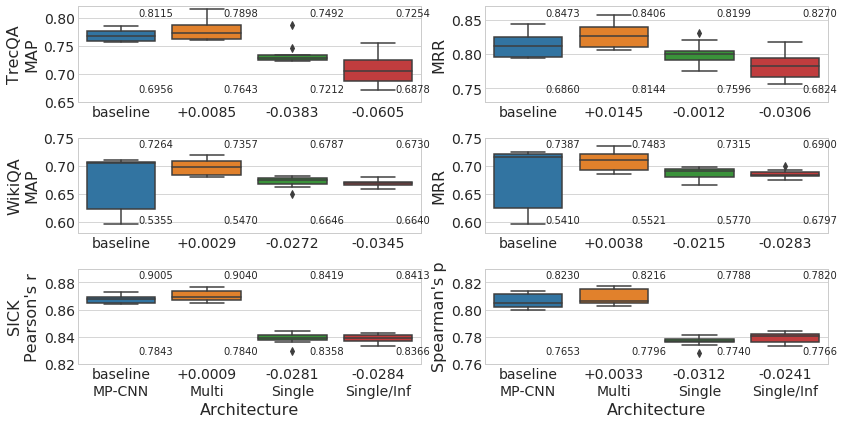

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 6)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.boxplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('TrecQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.65, 0.82))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_map_intervals[a][1])

ax = plt.subplot(322)
sns.boxplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.73, 0.87))
ax.xaxis.set_ticklabels([trec_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_mrr_intervals[a][1])

ax = plt.subplot(323)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('WikiQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.58, 0.75))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][1])

ax = plt.subplot(324)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.58, 0.75))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][1])

ax = plt.subplot(325)
sns.boxplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("SICK\nPearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.82, 0.89))
ax.xaxis.set_ticklabels([sick_pearson_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_pearson_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_pearson_intervals[a][1])

ax = plt.subplot(326)
sns.boxplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.76, 0.83))
ax.xaxis.set_ticklabels([sick_spearman_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_spearman_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_spearman_intervals[a][1])
plt.tight_layout()
# plt.subplots_adjust(top=0.8, hspace=0.2)
plt.savefig('window_arch_violin.pdf')